# Приоритезация гипотез и анализ A/B-теста

В данном проекте мы приоритезируем список гипотез для увеличения выручки и проанализируем результаты A/B-теста.   
В качестве данных для проведения необходимых расчетов используются файлы: *hypothesis.csv* с формулировками гипотез и их параметрами для расчета приоритета, *orders.csv* с данными по совершенным заказам и *visitors.csv*, содержащий данные о визитах.  
По итогам анализа сделаем вывод об успешности проведенного теста. 

## Загрузка и знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

visitors = pd.read_csv('/datasets/visitors.csv')

orders = pd.read_csv('/datasets/orders.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.duplicated().value_counts()

False    9
dtype: int64

In [5]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
visitors.duplicated().value_counts()

False    62
dtype: int64

In [8]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [10]:
orders.duplicated().value_counts()

False    1197
dtype: int64

In [11]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Проверим наличие одних и тех же пользователей в обеих группах одновременно

In [12]:
usersAset = set(orders[orders['group'] == 'A']['visitorId'].unique())

usersBset = set(orders[orders['group'] == 'B']['visitorId'].unique())

In [13]:
joint_users = usersAset.intersection(usersBset)

len(joint_users)

58

*58 пользователей оказались в обеих группах одновременно. Создадим новую таблицу с данными о заказах без этих пользователей*

In [14]:
orders_new = orders[np.logical_not(orders['visitorId'].isin(joint_users))]

*Дубликатов нет, типы данных соответствуют*

Приведем названия столбцов таблицы с гипотезами к нижнему регистру и увеличим ширину столбцов и самой таблицы для удобства прочтения гипотезы.

In [15]:
hypothesis.columns = hypothesis.columns.str.lower()

In [16]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

## Приоритизация гипотез

Применим фреймворк ICE для приоритизации и выясним топ-5 гипотез

In [17]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(1)

hypothesis_ice = hypothesis.sort_values(by=['ICE'], ascending=False)

In [18]:
hypothesis_ice.head(5)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0


Применим фреймворк RICE для приоритизации и выясним топ-5 гипотез

In [19]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['ICE']

hypothesis_rice = hypothesis.sort_values(by=['RICE'], ascending=False)

In [20]:
hypothesis_rice.style.bar(subset=['RICE', 'ICE'], align='mid', color='#5fba7d')

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,39.9
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,8.8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,3.9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


*В топ-5 остались те же гипотезы, что и при сортировке по ICE, только их расположение изменилось за счет того, что приоритет RICE учитывает охват пользователей. По сути приоритет RICE показывает увеличенный во столько раз ICE, во сколько баллов был оценен охват пользователей.   
Приоритетнее гипотезы с бОльшим охватом при прочих равных.*

*В первую очередь нужно проверить гипотезы с большим охватом пользователей. Добавив форму подписки на основные страницы, мы сможем собрать базу лояльных клиентов и совершать рассылки с акциями и распродажами, а также с персональными рекомендациями, увеличив этим средний чек и количество заказов.  
А для повышения конверсии проверить гипотезу с добавлением рекомендаций товаров на сайте.*

## Анализ A/B-теста

Для анализа кумулятивных значений метрик разделим данные о визитах по группам

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [22]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

Создадим таблицы с кумулятивными данными

In [23]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateA': 'sum'})
    ,axis=1)                
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [24]:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date': 'max', 'visitorsPerDateB': 'sum'})
    ,axis=1)                
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Данные по заказам также разделим по группам, сгруппируем по датам и применим соответствующие агрегирующие функции для подсчета количества транзакций и суммирования выручки

In [25]:
ordersADaily = (orders_new[orders_new['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

In [26]:
ordersBDaily = (orders_new[orders_new['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

Создадим таблицы с кумулятивными данными

In [27]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
    .agg({'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [28]:
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
    .agg({'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

### График кумулятивной выручки по группам

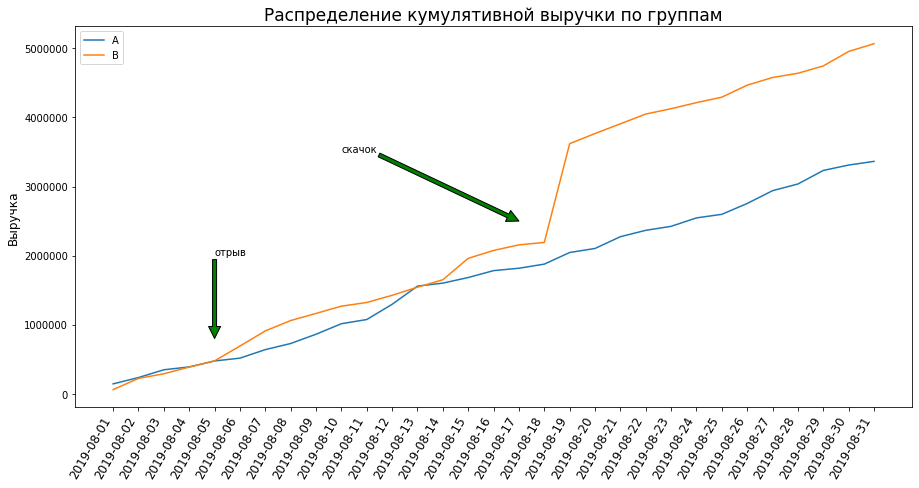

In [29]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(ordersACummulative['date'], ordersACummulative['revenueCummulativeA'], label='A')
ax.plot(ordersBCummulative['date'], ordersBCummulative['revenueCummulativeB'], label='B')

plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.ylabel("Выручка", size=12)
plt.title("Распределение кумулятивной выручки по группам", size=17)
ax.legend()

plt.annotate('скачок', xy=('2019-08-17', 2500000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))

plt.show()

*В начале эксперимента выручки групп А и B имели незначительное различие, но со второй половины августа выручка группы B резко увеличилась и продолжает лидировать*

### График кумулятивного среднего чека по группам

In [30]:
check_a = ordersACummulative['revenueCummulativeA'] / ordersACummulative['ordersCummulativeA']

check_b = ordersBCummulative['revenueCummulativeB'] / ordersBCummulative['ordersCummulativeB']

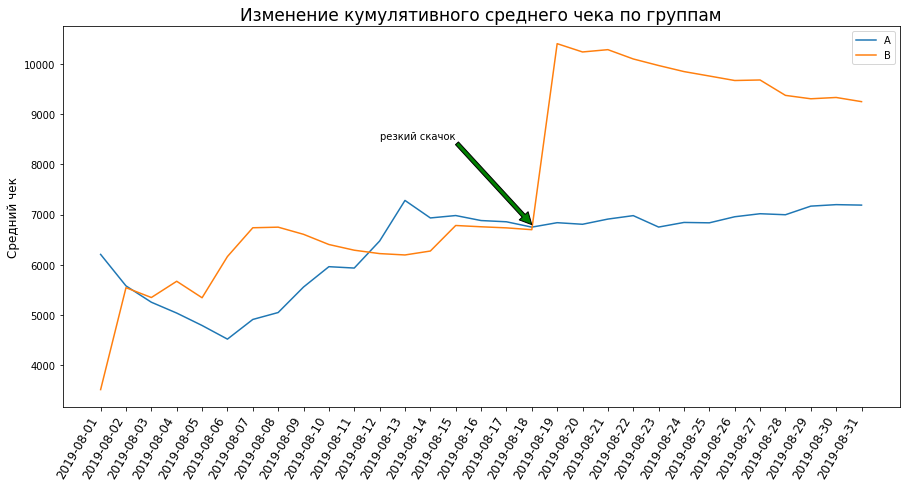

In [31]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(ordersACummulative['date'], check_a, label='A')
ax.plot(ordersBCummulative['date'], check_b, label='B')

plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.ylabel("Средний чек", size=12)
plt.title("Изменение кумулятивного среднего чека по группам", size=17)
ax.legend()

plt.annotate('резкий скачок', xy=('2019-08-18', 6800), xytext=('2019-08-12', 8500),
            arrowprops=dict(facecolor='g'))


plt.show()

*В начале эксперимента средний чек обеих групп разнонаправленно колебался, но со второй половины августа, как и выручка, средний чек группы B совершил резкий скачок вверх, в группе А остался практически на том же уровне. Нужно выяснить с чем связаны покупки более дорогих товаров в группе B, возможно есть выбросы*

### График относительного изменения кумулятивного среднего чека

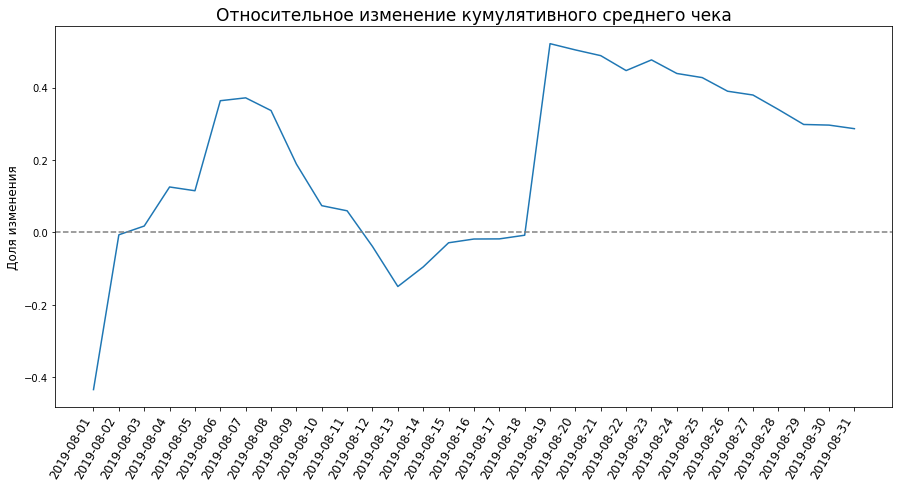

In [32]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(ordersACummulative['date'], (check_b / check_a) - 1)
ax.axhline(y=0, color='grey', linestyle='--')

plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.ylabel("Доля изменения", size=12)
plt.title("Относительное изменение кумулятивного среднего чека", size=17)


plt.show()

*На графике видны множественные резкие перепады на существенные величины, что может говорить о совершении аномальных заказов*

### График кумулятивной конверсии по группам

Соединим таблицы с визитами и таблицы с заказами по соответствующим группам

In [33]:
cumulativeDataA =  visitorsACummulative.merge(ordersACummulative, on='date')

cumulativeDataB =  visitorsBCummulative.merge(ordersBCummulative, on='date')

In [34]:
conversionA = cumulativeDataA['ordersCummulativeA'] / cumulativeDataA['visitorsCummulativeA']

conversionB = cumulativeDataB['ordersCummulativeB'] / cumulativeDataB['visitorsCummulativeB']

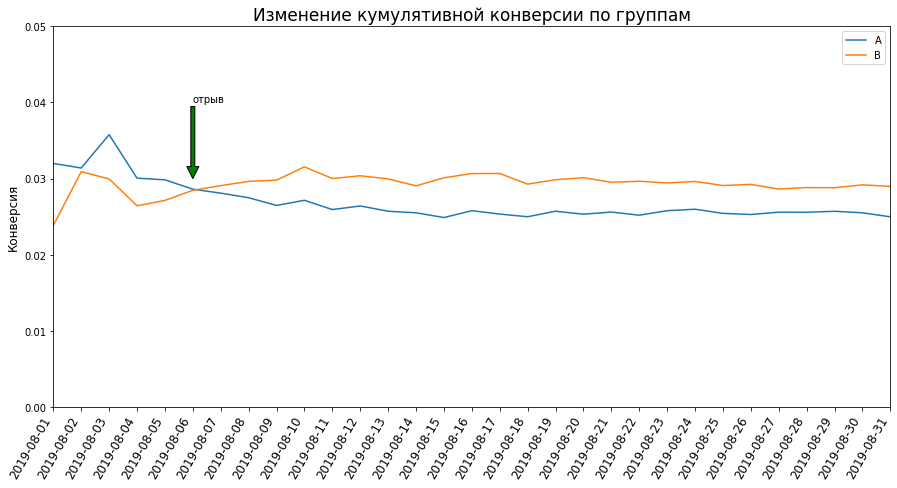

In [35]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(cumulativeDataA['date'], conversionA, label='A')
ax.plot(cumulativeDataB['date'], conversionB, label='B')

plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.ylabel("Конверсия", size=12)
plt.title("Изменение кумулятивной конверсии по группам", size=17)
plt.annotate('отрыв', xy=('2019-08-06', 0.03), xytext=('2019-08-06', 0.04),
            arrowprops=dict(facecolor='g'))
ax.legend()
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05])

plt.show()

*В начале эксперимента конверсия группы А была выше, но со временем конверсия группы B начала увеличиваться и постепенно выровнялась на уровне, выше уровня конверсии группы А*

### График относительного изменения кумулятивной конверсии

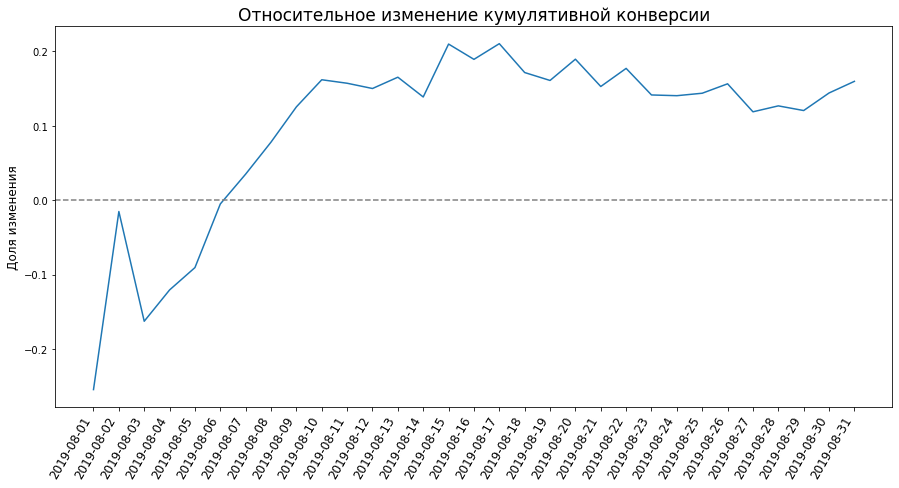

In [36]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(cumulativeDataA['date'], (conversionB / conversionA) - 1)
ax.axhline(y=0, color='grey', linestyle='--')

plt.xticks(rotation=60, horizontalalignment='right', fontsize=12)
plt.title("Относительное изменение кумулятивной конверсии", size=17)
plt.ylabel("Доля изменения", size=12)


plt.show()

*После выхода относительных значений изменения кумулятивной конверсии из отрицательной зоны был резкий рост на уровень 15-20 %, но со временем значения стабилизировались в диапазоне между 10 и 15*

### Точечный график  и расчет перцентилей количества заказов на пользователя

Сгруппируем данные с заказами по идентификаторам пользователей и подсчитаем сколько заказов совершил каждый из них

In [37]:
ordersByUsers = (orders_new.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique}))

ordersByUsers.columns = ['visitorId', 'transactions']

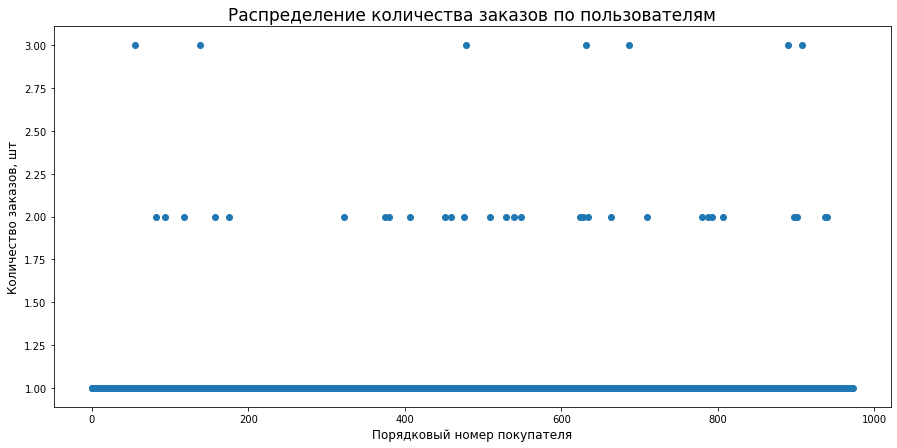

In [38]:
x_values = pd.Series(range(0,len(ordersByUsers['visitorId'])))

fig, ax = plt.subplots(figsize=(15, 7))

ax.scatter(x_values, ordersByUsers['transactions'])
plt.title("Распределение количества заказов по пользователям", size=17)
plt.xlabel("Порядковый номер покупателя", size=12)
plt.ylabel("Количество заказов, шт", size=12)

plt.show()

*Большинство пользователей сделали не более 3 заказов*

Посчитаем перцентили количества заказов на одного пользователя

In [39]:
percentiles = np.percentile(ordersByUsers['transactions'], [95, 99])

print(f'\033[1m95-й\033[0m перцентиль количества заказов на пользователя: \033[1m\033[34m{percentiles[0]}\033[0m')
print()
print(f'\033[1m99-й\033[0m перцентиль количества заказов на пользователя: \033[1m\033[34m{percentiles[1]}\033[0m')

95-й перцентиль количества заказов на пользователя: 1.0

99-й перцентиль количества заказов на пользователя: 2.0


*Определим границу аномальных пользователей в 1 заказ и отсеим тех, кто сделал больше*

### Точечный график и расчет перцентилей стоимостей заказов

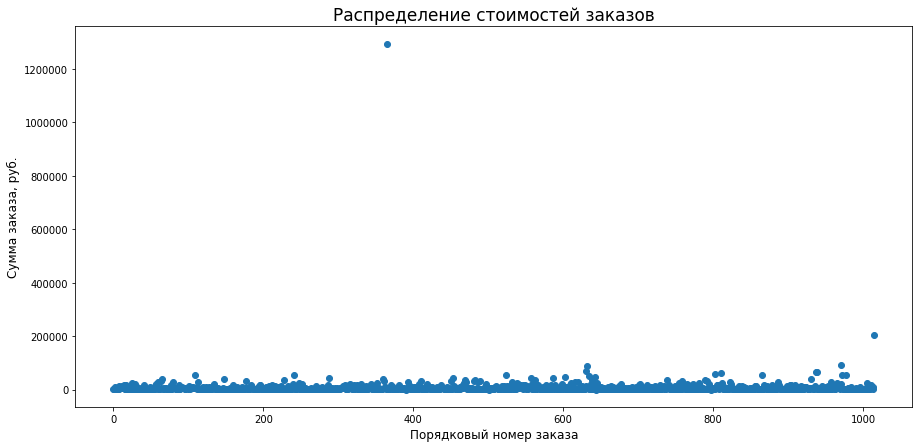

In [40]:
x_values = pd.Series(range(0,len(orders_new['revenue'])))

fig, ax = plt.subplots(figsize=(15, 7))

ax.scatter(x_values, orders_new['revenue'])
plt.title("Распределение стоимостей заказов", size=17)
plt.ylabel("Сумма заказа, руб.", size=12)
plt.xlabel("Порядковый номер заказа", size=12)


plt.show()

*Практически все заказы дешевле 50 тысяч, за редким исключением*

Посчитаем перцентили стоимостей заказов

In [41]:
revenues_perc = [int(x) for x in np.percentile(orders_new['revenue'], [95, 99])]

print(f'\033[1m95-й\033[0m перцентиль стоимостей заказов: \033[1m\033[34m{revenues_perc[0]}\033[0m')
print()
print(f'\033[1m99-й\033[0m перцентиль стоимостей заказов: \033[1m\033[34m{revenues_perc[1]}\033[0m')

95-й перцентиль стоимостей заказов: 26785

99-й перцентиль стоимостей заказов: 53904


*Определим границу аномальных стоимостей заказов в 30000 и уберем те, стоимость которых больше*

### Статистическая значимость различий в конверсии между группами по «сырым» данным

Создадим таблицы sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули

In [42]:
ordersByUsersA = (orders_new[orders_new['group'] == 'A'].groupby('visitorId', as_index=False)
                  .agg({'transactionId': pd.Series.nunique}))

ordersByUsersA.columns = ['visitorId', 'transactions']

ordersByUsersB = (orders_new[orders_new['group'] == 'B'].groupby('visitorId', as_index=False)
                  .agg({'transactionId': pd.Series.nunique}))

ordersByUsersB.columns = ['visitorId', 'transactions']

In [43]:
nullsA = pd.Series(0, index=np.arange(visitorsADaily['visitorsPerDateA'].sum() 
                                      - len(ordersByUsersA['transactions'])), name='transactions')

nullsB = pd.Series(0, index=np.arange(visitorsBDaily['visitorsPerDateB'].sum() 
                                      - len(ordersByUsersB['transactions'])), name='transactions')

sampleA = pd.concat([ordersByUsersA['transactions'], nullsA],axis=0)

sampleB = pd.concat([ordersByUsersB['transactions'], nullsB],axis=0)

1. Нулевая гипотеза: Различий в конверсии между группами A и B по «сырым» данным нет
2. Альтернативная гипотеза: Различия в конверсии между группами A и B по «сырым» данным есть

In [44]:
p_value_c = st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]

growth_с = sampleB.mean() / sampleA.mean() - 1

In [45]:
print(f'Cтатистическая значимость различий в \033[1mконверсии\033[0m между группами по «сырым» данным: \033[1m\033[34m{p_value_c:.4f}\033[0m')
print()
print(f'Относительный прирост \033[1mконверсии\033[0m: \033[1m\033[34m{growth_с:.1%}\033[0m')

Cтатистическая значимость различий в конверсии между группами по «сырым» данным: 0.0110

Относительный прирост конверсии: 16.0%


*p-value меньше 0.05, это значит что различия в конверсии между группами по «сырым» данным статистически значимы, при приросте 16%*  
*Отклоняем нулевую гипотезу в пользу альтернативной*

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

1. Нулевая гипотеза: Различий в среднем чеке заказа между группами A и B по «сырым» данным нет
2. Альтернативная гипотеза: Различия в среднем чеке заказа между группами A и B по «сырым» данным есть

In [46]:
p_value_r = st.mannwhitneyu(orders_new[orders_new['group']=='A']['revenue'], orders_new[orders_new['group']=='B']['revenue']
                            , alternative = 'two-sided')[1]

growth_r = orders_new[orders_new['group']=='B']['revenue'].mean() / orders_new[orders_new['group']=='A']['revenue'].mean() - 1

In [47]:
print(f'Cтатистическая значимость различий в \033[1mсреднем чеке\033[0m заказа между группами по «сырым» данным: \033[1m\033[34m{p_value_r:.4f}\033[0m')
print()
print(f'Относительный прирост \033[1mсреднего чека\033[0m: \033[1m\033[34m{growth_r:.1%}\033[0m')

Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным: 0.8295

Относительный прирост среднего чека: 28.7%


*p-value больше 0.05, статистически значимых отличий в среднем чеке между группами по «сырым» данным нет, хотя относительный прирост 28.7%  
Нулевую гипотезу отвергнуть не можем*

### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Соберем пользователей, совершивших аномальные заказы по количеству и по стоимости в одну таблицу

In [48]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['transactions'] > 1]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['transactions'] > 1]['visitorId']], axis=0)

usersWithExpensiveOrders = orders_new[orders_new['revenue'] > 30000]['visitorId']

abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates()
                 .sort_values())

Отфильтруем пользователей в данных о количестве совершенных заказов

In [49]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['transactions']
                     , nullsA], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['transactions']
                     , nullsB], axis=0)

1. Нулевая гипотеза: Различий в конверсии между группами A и B по «очищенным» данным нет
2. Альтернативная гипотеза: Различия в конверсии между группами A и B по «очищенным» данным есть

In [50]:
p_value_cf = st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]

growth_сf = sampleBFiltered.mean() / sampleAFiltered.mean() - 1

In [51]:
print(f'Cтатистическая значимость различий в \033[1mконверсии\033[0m между группами по «очищенным» данным: \033[1m\033[34m{p_value_cf:.4f}\033[0m')
print()
print(f'Относительный прирост \033[1mконверсии\033[0m: \033[1m\033[34m{growth_сf:.1%}\033[0m')

Cтатистическая значимость различий в конверсии между группами по «очищенным» данным: 0.0125

Относительный прирост конверсии: 18.0%


*p-value стал еще меньше, это значит что различия в конверсии между группами действительно статистически значимы, и к тому же прирост конверсии вырос и составляет 18%  
Отклоняем нулевую гипотезу и принимаем альтернативную*

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

1. Нулевая гипотеза: Различий в среднем чеке заказа между группами A и B по «очищенным» данным нет
2. Альтернативная гипотеза: Различия в среднем чеке заказа между группами A и B по «очищенным» данным есть

In [52]:
ordersFiltered = orders_new[np.logical_not(orders_new['visitorId'].isin(abnormalUsers))]

In [53]:
p_value_rf = st.mannwhitneyu(ordersFiltered[ordersFiltered['group']=='A']['revenue']
                             , ordersFiltered[ordersFiltered['group']=='B']['revenue']
                             , alternative = 'two-sided')[1]

growth_rf = (ordersFiltered[ordersFiltered['group']=='B']['revenue'].mean() 
            / ordersFiltered[ordersFiltered['group']=='A']['revenue'].mean() - 1)

In [54]:
print(f'Cтатистическая значимость различий в \033[1mсреднем чеке\033[0m заказа между группами по «очищенным» данным: \033[1m\033[34m{p_value_rf:.4f}\033[0m')
print()
print(f'Относительный прирост \033[1mсреднего чека\033[0m: \033[1m\033[34m{growth_rf:.1%}\033[0m')

Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным: 0.8290

Относительный прирост среднего чека: -1.1%


*p-value практически не изменился и остался больше 0.05, значит статистически значимых отличий в среднем чеке между группами по «очищенным» данным нет, хотя теперь группа B и отстает по сумме среднего чека на 1.1%  
Отклонить нулевую гипотезу мы не можем*

## Вывод

Мы загрузили данные, ознакомились с ними, проверили что все типы данных соответствуют значениям. В таблице с гипотезами привели названия столбцов к нижнему регистру.  
Также мы выяснили, что некоторые пользователи попали сразу в обе группы теста, собрали их идентификаторы и создали новую таблицу с заказами не учитывая их.  
Провели приоритизацию гипотез с помощью фреймворков ICE и RICE и выяснили, что в первую очередь нужно проверить гипотезу с добавлением формы подписки на все основные страницы сайта.  
Рассчитали и построили графики кумулятивных среднего чека и конверсии, а также графики их относительного изменения.  
С помощью точечных графиков и расчета перцентилей выявили аномалии в количествах и суммах совершаемых заказов.  
Провели проверку гипотез о наличии различий между группами по среднему чеку и конверсии на "сырых" и "очищенных" данных с помощью U-критерия Манна-Уитни. Рассчитали относительный прирост данных показателей.

Избавившись от аномальных данных и проведя анализ A/B-теста можно принять решение остановить тест и зафиксировать победу группы B.  
Цель по увеличению выручки достигнута.  
Конверсия увеличилась на 18% и это значение является статистически значимым, при этом по среднему чеку статистически значимых изменений нет.  
Посетители чаще стали совершать покупки, но предпочтения по суммам и количеству заказов остались на прежнем уровне.